In [ ]:
!pip3 install -U ucimlrepo
#!pip install --upgrade nbformat

In [ ]:
from ucimlrepo import fetch_ucirepo, list_available_datasets

# check which datasets can be imported
list_available_datasets()

-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Annealing                                                                               3     
Audiology (Standardized)                                                                8     
Auto MPG                                                                                9     
Automobile                                                                              10    
Balance Scale                                                                           12    
Balloons                       

In [ ]:
# import dataset
#diabetes_us = fetch_ucirepo(id=45)
diabetes_us = fetch_ucirepo(name='Diabetes 130-US Hospitals for Years 1999-2008')

# access data
X = diabetes_us.data.features
y = diabetes_us.data.targets
# train model e.g. sklearn.linear_model.LinearRegression().fit(X, y)

# access metadata
print(diabetes_us.metadata.uci_id)
print(diabetes_us.metadata.num_instances)
print(diabetes_us.metadata.additional_info.summary)

# access variable info in tabular format
print(diabetes_us.variables)


/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


296
101766
The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
(1)	It is an inpatient encounter (a hospital admission).
(2)	It is a diabetic encounter, that is, one during which any kind of diabetes was entered into the system as a diagnosis.
(3)	The length of stay was at least 1 day and at most 14 days.
(4)	Laboratory tests were performed during the encounter.
(5)	Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab tests performed, HbA1c test result, diagnosis, number of medications, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalizati

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor

In [ ]:
np.random.seed(42)

In [ ]:
diabetes_df = pd.read_csv("https://archive.ics.uci.edu/static/public/296/data.csv", low_memory=False)
diabetes_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
print(diabetes_df['time_in_hospital'].unique())
print(diabetes_df['age'].unique())
print(diabetes_df['race'].unique()) # we were thinking if we can get heights information based on race, but too many Other and NaN values hinders us from doing it

[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']


In [ ]:
diabetes_df.shape

(101766, 50)

In [ ]:
diabetes_df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [ ]:
diabetes_df.dtypes

,0
encounter_id,int64
patient_nbr,int64
race,object
gender,object
age,object
weight,object
admission_type_id,int64
discharge_disposition_id,int64
admission_source_id,int64
time_in_hospital,int64


In [ ]:
diabetes_df[['gender', 'age']].value_counts().reset_index()

,gender,age,count
0,Female,[70-80),13985
1,Male,[70-80),12081
2,Male,[60-70),11421
3,Female,[60-70),11061
4,Female,[80-90),10515
5,Male,[50-60),8684
6,Female,[50-60),8572
7,Male,[80-90),6682
8,Male,[40-50),4874
9,Female,[40-50),4811


# Length Of Stay Distribution

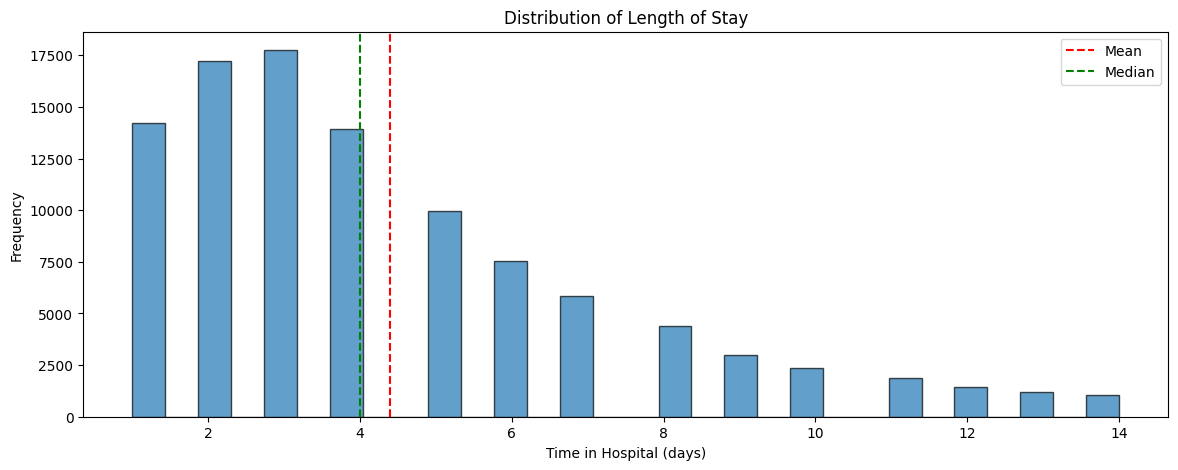

In [ ]:
#To have a rough understanding of distribution of our target variable(LOS) first
plt.figure(figsize=(14, 5))
plt.hist(diabetes_df['time_in_hospital'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Time in Hospital (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Length of Stay')
plt.axvline(diabetes_df['time_in_hospital'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(diabetes_df['time_in_hospital'].median(), color='green', linestyle='--', label='Median')
plt.legend()
plt.show()

# Data Pre-processing

### Handle missing values

In [ ]:
#handle missing values first
diabetes_df.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,2273
gender,0
age,0
weight,98569
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0


In [ ]:
# calculate the missing ratio to see what data variables are useful
miss = diabetes_df.isna().mean().sort_values(ascending=False).to_frame("missing_ratio")
miss.head(15)

,missing_ratio
weight,0.968585
max_glu_serum,0.947468
A1Cresult,0.832773
medical_specialty,0.490822
payer_code,0.395574
race,0.022336
diag_3,0.013983
diag_2,0.003518
diag_1,0.000206
patient_nbr,0.000000


**Looking at the missing values ratio, we find out that the problematic variables (major missing data issues):**

* A1Cresult - 83.3% missing (only ~17% of data available)
* max_glu_serum - 94.7% missing (only ~5% of data available)
* weight - 96.9% missing (only ~3% of data available)

**Thus, we will not conduct analysis on these variables.**

In [ ]:
diabetes_df = diabetes_df.drop(columns=['weight', 'max_glu_serum', 'A1Cresult'])

In [ ]:
#ids coloumns are not useful
diabetes_df = diabetes_df.drop(columns=['encounter_id', 'patient_nbr'])

We noticed that there are many missing values represented by '?'. So we need to fix this.

In [ ]:
#We spot '?' in the dataset so we replace them with NaN for better identification
for col in diabetes_df.select_dtypes(include=['object']).columns:
    diabetes_df[col] = diabetes_df[col].replace('?', np.nan)

In [ ]:
# Re-check NaN, especially in categorical columns
diabetes_df.isnull().sum()[diabetes_df.isnull().sum() > 0]

,0
race,2273
payer_code,40256
medical_specialty,49949
diag_1,21
diag_2,358
diag_3,1423


### Age feature - group the age groups into 4 simplified categories

In [ ]:
def simplify_age_group(age_str):
    if pd.isna(age_str):
        return "Unknown"
    age_num = int(age_str.split('-')[0].replace('[', ''))
    if age_num < 30:
        return "Young (<30)"
    elif age_num < 50:
        return "Middle (30-49)"
    elif age_num < 70:
        return "Older (50-69)"
    else:
        return "Elderly (70+)"

diabetes_df["age_simplified"] = diabetes_df["age"].apply(simplify_age_group)
diabetes_df["age_simplified"].describe().T

,age_simplified
count,101766
unique,4
top,Elderly (70+)
freq,46058


In [ ]:
#Drop original age feature
diabetes_df = diabetes_df.drop('age', axis=1)

### Categorize ICD-9 diagnosis codes into major disease groups

In [ ]:
def categorize_diagnosis(diag_code):
    if pd.isna(diag_code):
        return 'Unknown'

    diag_str = str(diag_code)

    # Extract numeric part
    if diag_str.startswith('V') or diag_str.startswith('E'):
        return 'Other'

    try:
        diag_num = float(diag_str)
    except:
        return 'Other'

    # Categorize based on ICD-9 code ranges
    if 390 <= diag_num <= 459 or diag_num == 785:
        return 'Circulatory'
    elif 460 <= diag_num <= 519 or diag_num == 786:
        return 'Respiratory'
    elif 520 <= diag_num <= 579 or diag_num == 787:
        return 'Digestive'
    elif 250 <= diag_num < 251:
        return 'Diabetes'
    elif 800 <= diag_num <= 999:
        return 'Injury'
    elif 710 <= diag_num <= 739:
        return 'Musculoskeletal'
    elif 580 <= diag_num <= 629 or diag_num == 788:
        return 'Genitourinary'
    elif 140 <= diag_num <= 239:
        return 'Neoplasms'
    else:
        return 'Other'

In [ ]:
diabetes_df['primary_diag_category'] = diabetes_df['diag_1'].apply(categorize_diagnosis)
print("Created primary_diag_category from diag_1")

diabetes_df['secondary_diag_category'] = diabetes_df['diag_2'].apply(categorize_diagnosis)
print("Created secondary_diag_category from diag_2")

diabetes_df['tertiary_diag_category'] = diabetes_df['diag_3'].apply(categorize_diagnosis)
print("Created tertiary_diag_category from diag_3")

Created primary_diag_category from diag_1
Created secondary_diag_category from diag_2
Created tertiary_diag_category from diag_3


**The categorized diagnosis will have to be encoded later in order to be able to fit into the model.**

### Medication Features Engineering

In [ ]:
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]

In [ ]:
diabetes_df['total_med_changes'] = 0
for med_col in medication_cols:
    diabetes_df['total_med_changes'] += (diabetes_df[med_col].isin(['Up', 'Down'])).astype(int)

In [ ]:
diabetes_df['total_med_changes'].head()

,total_med_changes
0,0
1,1
2,0
3,1
4,0


### Healthcare Utilization Features Engineering

In [ ]:
diabetes_df['total_visits'] = (
    diabetes_df.get('number_outpatient', 0) +
    diabetes_df.get('number_inpatient', 0) +
    diabetes_df.get('number_emergency', 0)
).astype(np.int64)

In [ ]:
diabetes_df['procedure_intensity'] = (
    diabetes_df.get('num_lab_procedures', 0) +
    diabetes_df.get('num_procedures', 0)
).astype(np.int64)

In [ ]:
#to avoid the denominator becomes zero later
denom = diabetes_df['number_diagnoses'].replace(0, np.nan)

In [ ]:
diabetes_df['medication_intensity'] = np.where(
    denom.isna(),#condition
    0.0,#return value if condition True
    diabetes_df['num_medications'] / denom # return value if condition False
).astype(float)

# Feature Engineering

Here we will create a new feature representing the admission-dishcarge path.

In [ ]:
for c in ['admission_type_id','discharge_disposition_id']:
    if c in diabetes_df.columns: diabetes_df[c] = pd.to_numeric(diabetes_df[c], errors='coerce')

# We map the type into category corresponds to the type number first
adm_map = {1:'Emergency',2:'Urgent',3:'Elective',4:'Newborn',7:'Trauma'}
diabetes_df['admission_cat'] = diabetes_df['admission_type_id'].map(adm_map).fillna('Other')

#We want to groups numeric discharge codes into 7 categories
home_set={1}; transfer_set={2}; postacute_set={3,4,5,6}; ama_set={7}; death_set={11,19,20,21}; hospice_set={50,51}
def discharge_bucket(x):
    if pd.isna(x): return 'Unknown'
    x=int(x)
    if x in home_set: return 'Home'
    if x in postacute_set: return 'PostAcute'
    if x in transfer_set: return 'Transfer'
    if x in ama_set: return 'AMA'
    if x in death_set: return 'Died'
    if x in hospice_set: return 'Hospice'
    return 'Other'

diabetes_df['discharge_cat'] = diabetes_df['discharge_disposition_id'].apply(discharge_bucket)

#Turn the discharge cat into binary variable (manual one-hot encoding?)
diabetes_df['discharged_to_home']    = (diabetes_df['discharge_cat']=='Home').astype(int)
diabetes_df['postacute_discharge']   = (diabetes_df['discharge_cat']=='PostAcute').astype(int)
diabetes_df['transfer_discharge']    = (diabetes_df['discharge_cat']=='Transfer').astype(int)
diabetes_df['left_against_medical']  = (diabetes_df['discharge_cat']=='AMA').astype(int)
diabetes_df['in_hospital_mortality'] = (diabetes_df['discharge_cat']=='Died').astype(int)
diabetes_df['hospice_discharge']     = (diabetes_df['discharge_cat']=='Hospice').astype(int)

#create a new feature representing the admission-dishcarge path
diabetes_df['adm_dis_path'] = diabetes_df['admission_cat'].str.cat(diabetes_df['discharge_cat'], sep='→')
path_freq = diabetes_df['adm_dis_path'].value_counts()
diabetes_df['adm_dis_path_freq'] = diabetes_df['adm_dis_path'].map(path_freq)

#Creates binary features for the 10 most common pathways
K = 10
topK_paths = path_freq.index[:K]
for p in topK_paths:
    diabetes_df['path_' + p.replace('→','_to_')] = (diabetes_df['adm_dis_path']==p).astype(int)

#These two specific pathways are meaningful.
#'Emergency→PostAcute' means emergency patients needing extended care.
#'Elective→Home' means planned procedures with successful discharge.
diabetes_df['emergency_postacute'] = ((diabetes_df['admission_cat']=='Emergency') & (diabetes_df['postacute_discharge']==1)).astype(int)
diabetes_df['elective_home']       = ((diabetes_df['admission_cat']=='Elective') & (diabetes_df['discharged_to_home']==1)).astype(int)

display(diabetes_df[['admission_cat','discharge_cat','adm_dis_path']].head())


,admission_cat,discharge_cat,adm_dis_path
0,Other,Other,Other→Other
1,Emergency,Home,Emergency→Home
2,Emergency,Home,Emergency→Home
3,Emergency,Home,Emergency→Home
4,Emergency,Home,Emergency→Home


In [ ]:
#We explore the correalation of variables with respect to time_in_hospital
print(diabetes_df[['time_in_hospital','discharged_to_home','postacute_discharge','transfer_discharge',
          'left_against_medical','in_hospital_mortality','hospice_discharge',
          'adm_dis_path_freq','emergency_postacute','elective_home']]
      .corr(numeric_only=True)['time_in_hospital'].sort_values(ascending=False))

time_in_hospital         1.000000
postacute_discharge      0.256376
emergency_postacute      0.166096
in_hospital_mortality    0.016537
transfer_discharge      -0.026104
left_against_medical    -0.040923
elective_home           -0.103092
adm_dis_path_freq       -0.148953
discharged_to_home      -0.280528
hospice_discharge             NaN
Name: time_in_hospital, dtype: float64


**We can identify there are 2 variable correlate with longer hospital stays, which are postacute_discharge(discharge categories) and emergency_postacute(adm-dis-path).**

In [ ]:
#create some interaction features
diabetes_df['num_meds_per_diagnosis'] = (
    diabetes_df['num_medications'] /
    diabetes_df['number_diagnoses'].replace(0, 1)
)
diabetes_df['procedures_per_diagnosis'] = (
    diabetes_df['num_procedures'] /
    diabetes_df['number_diagnoses'].replace(0, 1)
)

diabetes_df['labs_per_diagnosis'] = (
    diabetes_df['num_lab_procedures'] /
    diabetes_df['number_diagnoses'].replace(0, 1)
)

In [ ]:
diabetes_df['care_intensity_score'] = (
    diabetes_df['num_medications'] * 0.3 +
    diabetes_df['num_procedures'] * 0.3 +
    diabetes_df['num_lab_procedures'] * 0.2 +
    diabetes_df['number_diagnoses'] * 0.2
)

In [ ]:
# Square terms for important continuous features
diabetes_df['num_medications_squared'] = diabetes_df['num_medications'] ** 2
diabetes_df['num_lab_procedures_squared'] = diabetes_df['num_lab_procedures'] ** 2
diabetes_df['number_diagnoses_squared'] = diabetes_df['number_diagnoses'] ** 2

### Separate numeric features and categorical features

In [ ]:
numeric_features = diabetes_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = diabetes_df.select_dtypes(include=['object']).columns.tolist()

In [ ]:
# Remove target from features list
if 'time_in_hospital' in numeric_features:
    numeric_features.remove('time_in_hospital')

In [ ]:
# Remove ICD-9 codes and original admission/discharge IDs as they are now engineered alr
drop_cols = ['diag_1', 'diag_2', 'diag_3', 'admission_type_id', 'discharge_disposition_id']
X_processed = diabetes_df.drop(columns=['time_in_hospital'] + drop_cols, errors='ignore').copy()
y = diabetes_df['time_in_hospital'].values

In [ ]:
# Update categorical_features list after dropping original diagnosis and ID columns
categorical_features = [col for col in X_processed.columns if X_processed[col].dtype == 'object']
numeric_features = [col for col in X_processed.columns if X_processed[col].dtype != 'object']

## Imputing Missing values

In [ ]:
for col in categorical_features:
    X_processed[col] = X_processed[col].fillna('Missing')

In [ ]:
numeric_imputer = SimpleImputer(strategy='mean')
for col in numeric_features:
    X_processed[col] = numeric_imputer.fit_transform(X_processed[[col]])

In [ ]:
for col in categorical_features[:]:
    n_unique = diabetes_df[col].nunique()
    print(f"  - {col}: {n_unique} unique values")
    # Drop diagnosis codes (too many categories - will engineer features later)
    if col in ['diag_1', 'diag_2', 'diag_3']:
        categorical_features.remove(col)

  - race: 5 unique values
  - gender: 3 unique values
  - payer_code: 17 unique values
  - medical_specialty: 72 unique values
  - metformin: 4 unique values
  - repaglinide: 4 unique values
  - nateglinide: 4 unique values
  - chlorpropamide: 4 unique values
  - glimepiride: 4 unique values
  - acetohexamide: 2 unique values
  - glipizide: 4 unique values
  - glyburide: 4 unique values
  - tolbutamide: 2 unique values
  - pioglitazone: 4 unique values
  - rosiglitazone: 4 unique values
  - acarbose: 4 unique values
  - miglitol: 4 unique values
  - troglitazone: 2 unique values
  - tolazamide: 3 unique values
  - examide: 1 unique values
  - citoglipton: 1 unique values
  - insulin: 4 unique values
  - glyburide-metformin: 4 unique values
  - glipizide-metformin: 2 unique values
  - glimepiride-pioglitazone: 2 unique values
  - metformin-rosiglitazone: 2 unique values
  - metformin-pioglitazone: 2 unique values
  - change: 2 unique values
  - diabetesMed: 2 unique values
  - readmitte

# Encode Categorical Variables

**Becaues the number of values range from 2 to 72(which is not suitable for onehotencoding as it brings too many new columns), we will have to do 2 encoding strategies.**

In [ ]:
# One-hot encode categorical variables with fewer unique values
for col in categorical_features:
    n_unique = X_processed[col].nunique()

    if n_unique <= 10:  # One-hot encode if ≤10 categories
        ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        X_encoded = pd.DataFrame(ohe.fit_transform(X_processed[[col]]))
        encoded_feature_names = ohe.get_feature_names_out([col])
        encoded_df = pd.DataFrame(
            X_encoded,
            columns=encoded_feature_names,
            index=X_processed.index
        )
        # Concatenate encoded features to X_processed
        X_processed = pd.concat([X_processed, encoded_df], axis=1)

        # Drop original column
        X_processed = X_processed.drop(col, axis=1)
        print(f"One-hot encoded {col} ({n_unique} categories)")
    else:  # Label encode if >10 categories
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))
        print(f"Label encoded {col} ({n_unique} categories)")

One-hot encoded race (6 categories)
One-hot encoded gender (3 categories)
Label encoded payer_code (18 categories)
Label encoded medical_specialty (73 categories)
One-hot encoded metformin (4 categories)
One-hot encoded repaglinide (4 categories)
One-hot encoded nateglinide (4 categories)
One-hot encoded chlorpropamide (4 categories)
One-hot encoded glimepiride (4 categories)
One-hot encoded acetohexamide (2 categories)
One-hot encoded glipizide (4 categories)
One-hot encoded glyburide (4 categories)
One-hot encoded tolbutamide (2 categories)
One-hot encoded pioglitazone (4 categories)
One-hot encoded rosiglitazone (4 categories)
One-hot encoded acarbose (4 categories)
One-hot encoded miglitol (4 categories)
One-hot encoded troglitazone (2 categories)
One-hot encoded tolazamide (3 categories)
One-hot encoded examide (1 categories)
One-hot encoded citoglipton (1 categories)
One-hot encoded insulin (4 categories)
One-hot encoded glyburide-metformin (4 categories)
One-hot encoded glipizid

In [ ]:
X_processed.shape

(101766, 140)

**We can clearly tell that the dimenality of the features has increased after encoding. (which is as expected)**

In [ ]:
missing_cols = X_processed.columns[X_processed.isnull().any()].tolist()

In [ ]:
for col in missing_cols:
    # #Create missing indicator
    # X_processed[col + '_missing'] = X_processed[col].isna().astype(int)

    if X_processed[col].dtype == 'object':  # categorical
        # Fill with 'Unknown'
          X_processed[col] = X_processed[col].fillna('Unknown')
    else:  # numeric
        X_processed[col] = X_processed[col].fillna(-1) # -1 indicates missing

In [ ]:
# Check for missing values again to double confirm we have no missing values anymore
X_processed.isnull().sum().sort_values(ascending=False)

,0
admission_source_id,0
payer_code,0
medical_specialty,0
num_lab_procedures,0
num_procedures,0
...,...
discharge_cat_Died,0
discharge_cat_Home,0
discharge_cat_Other,0
discharge_cat_PostAcute,0


# Train-Test Split

In [ ]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)


print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")

Training set: 81,412 samples (80.0%)
Test set: 20,354 samples (20.0%)
Number of features: 140


#Feature Scaling

In [ ]:
#Ensure we have all features to be numerical before fit into the model
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:")
for col in non_numeric_cols:
    print(f"- {col}")

Non-numeric columns:


**The non-numerical columns are not able to be fit into the model.**

In [ ]:
#Great! We don't have non-numeric features so we can continue. Owise uncomment below to drop.
#X_train = X_train.drop(columns=non_numeric_cols)
#X_test = X_test.drop(columns=non_numeric_cols)

In [ ]:
# Standardize features (important for PCA and regularized regression)
scaler = RobustScaler() # here we use robust scaler instead of standard one to ignore outlier
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#PCA


In [ ]:
# Determine optimal number of components
# First, fit PCA with all components to see explained variance
pca_full = PCA(random_state=42)
pca_full.fit(X_train_scaled)

PCA(random_state=42)

In [ ]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

In [ ]:
# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {n_components_95}")

Number of components for 95% variance: 4


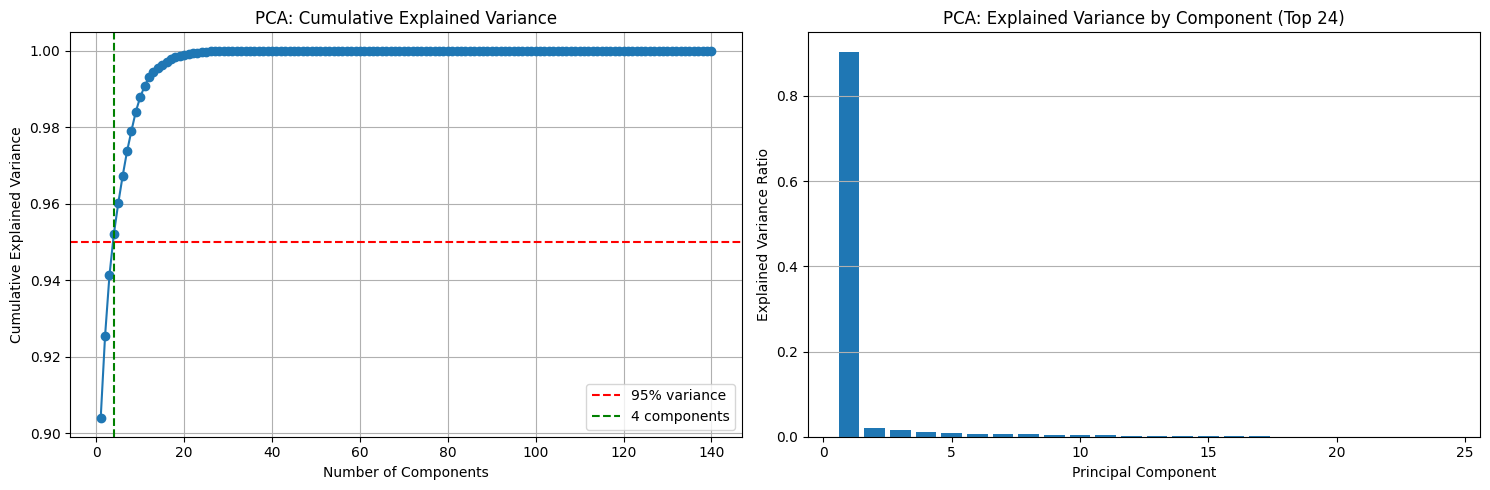

In [ ]:
# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: cumulative curve
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[0].axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} components')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA: Cumulative Explained Variance')
axes[0].legend()
axes[0].grid(True)

# Right: top-24 individual variances
axes[1].bar(range(1, 25), pca_full.explained_variance_ratio_[:24])
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('PCA: Explained Variance by Component (Top 24)')
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Apply PCA with optimal components
pca = PCA(n_components=n_components_95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA applied: {X_train.shape[1]} features → {n_components_95} components")
print(f"Total variance explained: {cumulative_variance[n_components_95-1]*100:.2f}%")

PCA applied: 140 features → 4 components
Total variance explained: 95.21%


**Now we're ready to fit this into the model!**

#Model Training and Evaluation


In [ ]:
# Dictionary to store results
results = {}

#For later evaluation of model performance
def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    """Train model and calculate evaluation metrics"""

    # Train model
    model.fit(X_tr, y_tr)

    # Predictions
    y_train_pred = model.predict(X_tr)
    y_test_pred = model.predict(X_te)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_test_pred))
    train_mae = mean_absolute_error(y_tr, y_train_pred)
    test_mae = mean_absolute_error(y_te, y_test_pred)
    train_r2 = r2_score(y_tr, y_train_pred)
    test_r2 = r2_score(y_te, y_test_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=5,
                                 scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()

    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse,
        'y_pred': y_test_pred
    }

    return results[name]

#Model 1: Ordinary Least Squares (Standard Linear Regression)


In [ ]:
ols_model = LinearRegression()
ols_results = evaluate_model('OLS', ols_model, X_train_pca, X_test_pca, y_train, y_test)

print(f"Training RMSE: {ols_results['train_rmse']:.4f}")
print(f"Test RMSE: {ols_results['test_rmse']:.4f}")
print(f"Training MAE: {ols_results['train_mae']:.4f}")
print(f"Test MAE: {ols_results['test_mae']:.4f}")
print(f"Training R²: {ols_results['train_r2']:.4f}")
print(f"Test R²: {ols_results['test_r2']:.4f}")
print(f"Cross-Validation RMSE: {ols_results['cv_rmse']:.4f}")

Training RMSE: 2.6745
Test RMSE: 2.6330
Training MAE: 2.0464
Test MAE: 2.0195
Training R²: 0.2019
Test R²: 0.2035
Cross-Validation RMSE: 2.6746


#Model 2: Ridge Regression (L2 Regularization)

In [ ]:
# Hyperparameter tuning for alpha
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_grid = GridSearchCV(Ridge(random_state=42), ridge_params, cv=5,
                          scoring='neg_root_mean_squared_error')
ridge_grid.fit(X_train_pca, y_train)

print(f"Best alpha: {ridge_grid.best_params_['alpha']}")

ridge_model = ridge_grid.best_estimator_
ridge_results = evaluate_model('Ridge', ridge_model, X_train_pca, X_test_pca, y_train, y_test)

print(f"Training RMSE: {ridge_results['train_rmse']:.4f}")
print(f"Test RMSE: {ridge_results['test_rmse']:.4f}")
print(f"Training MAE: {ridge_results['train_mae']:.4f}")
print(f"Test MAE: {ridge_results['test_mae']:.4f}")
print(f"Training R²: {ridge_results['train_r2']:.4f}")
print(f"Test R²: {ridge_results['test_r2']:.4f}")
print(f"Cross-Validation RMSE: {ridge_results['cv_rmse']:.4f}")

Best alpha: 100
Training RMSE: 2.6745
Test RMSE: 2.6330
Training MAE: 2.0464
Test MAE: 2.0195
Training R²: 0.2019
Test R²: 0.2035
Cross-Validation RMSE: 2.6746


Both OLS and Ridge Regression models demonstrate nearly **identical** performance, indicating minimal overfitting in the baseline linear model.

The R² score of ~0.2 reveals that the models explain only about 20% of the variance in hospital length of stay, suggesting low predictive power.

Notably, Ridge regularization with alpha=100 did not improve performance over standard OLS, suggesting that multicollinearity is not a significant issue in the PCA-transformed features, and the linear relationships captured by these models may be insufficient to fully explain the complexity of hospital length of stay. **The low R² indicates that non-linear models (Random Forest, XGBoost) may capture additional patterns and interactions that linear models miss, potentially yielding better predictive accuracy.**

#Model 3: Lasso Regression (L1 Regularization)


In [ ]:
# Hyperparameter tuning for alpha
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(random_state=42), lasso_params, cv=5,
                          scoring='neg_root_mean_squared_error')
lasso_grid.fit(X_train_pca, y_train)

print(f"Best alpha: {lasso_grid.best_params_['alpha']}")

lasso_model = lasso_grid.best_estimator_
lasso_results = evaluate_model('Lasso', lasso_model, X_train_pca, X_test_pca, y_train, y_test)

print(f"Training RMSE: {lasso_results['train_rmse']:.4f}")
print(f"Test RMSE: {lasso_results['test_rmse']:.4f}")
print(f"Training MAE: {lasso_results['train_mae']:.4f}")
print(f"Test MAE: {lasso_results['test_mae']:.4f}")
print(f"Training R²: {lasso_results['train_r2']:.4f}")
print(f"Test R²: {lasso_results['test_r2']:.4f}")
print(f"Cross-Validation RMSE: {lasso_results['cv_rmse']:.4f}")

Best alpha: 0.001
Training RMSE: 2.6745
Test RMSE: 2.6330
Training MAE: 2.0464
Test MAE: 2.0196
Training R²: 0.2019
Test R²: 0.2035
Cross-Validation RMSE: 2.6746


Lasso regression applies an L1 penalty that encourages sparsity in model coefficients, effectively performing feature selection.
The optimal regularization strength was α = 0.001, indicating that minimal shrinkage produced the best performance.

The model is almost identical to both the OLS and Ridge models.
Since PCA had already reduced feature multicollinearity, the L1 regularization had little impact.
Nonetheless, Lasso is useful for identifying key predictors in high-dimensional data before dimensionality reduction.

**The consistent performance across all three linear models (OLS, Ridge, and Lasso) with Test R² hovering around 0.2 reveals a fundamental limitation: linear models can only explain approximately 20% of the variance in hospital length of stay, regardless of the regularization strategy employed.**

#MODEL 4: RANDOM FOREST REGRESSOR

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,               # Deep enough to capture complexity
    min_samples_split=10,        # Prevents overfitting
    min_samples_leaf=5,
    max_features='sqrt',
    max_samples=0.8,            # Bootstrap 80% of data
    bootstrap=True,             # Enable bagging
    random_state=42,
    n_jobs=-1,
    verbose=0
)

In [ ]:
# Train Random Forest(use scaled features WITHOUT PCA)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', max_samples=0.8,
                      min_samples_leaf=5, min_samples_split=10,
                      n_estimators=400, n_jobs=-1, random_state=42)

In [ ]:
# Make predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

In [ ]:
# Calculate metrics
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

In [ ]:
# Display results
print("Random Forest - Performance Metrics")
print(f"Training RMSE: {rf_train_rmse:.4f} days")
print(f"Test RMSE: {rf_test_rmse:.4f} days")
print(f"Training MAE: {rf_train_mae:.4f} days")
print(f"Test MAE: {rf_test_mae:.4f} days")
print(f"Training R²: {rf_train_r2:.4f}")
print(f"Test R²: {rf_test_r2:.4f}")

Random Forest - Performance Metrics
Training RMSE: 2.0670 days
Test RMSE: 2.3103 days
Training MAE: 1.5549 days
Test MAE: 1.7508 days
Training R²: 0.5233
Test R²: 0.3868


In [ ]:
# Feature Importance - Top 10
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_}).sort_values('Importance', ascending=False)
print("Top 10 Most Important Features (Random Forest):")
print(rf_feature_importance.head(10).to_string(index=False))

Top 10 Most Important Features (Random Forest):
                   Feature  Importance
      care_intensity_score    0.122189
           num_medications    0.086434
   num_medications_squared    0.078044
        num_lab_procedures    0.058199
       procedure_intensity    0.058004
      medication_intensity    0.055911
    num_meds_per_diagnosis    0.055668
num_lab_procedures_squared    0.053891
        labs_per_diagnosis    0.044901
         medical_specialty    0.034224


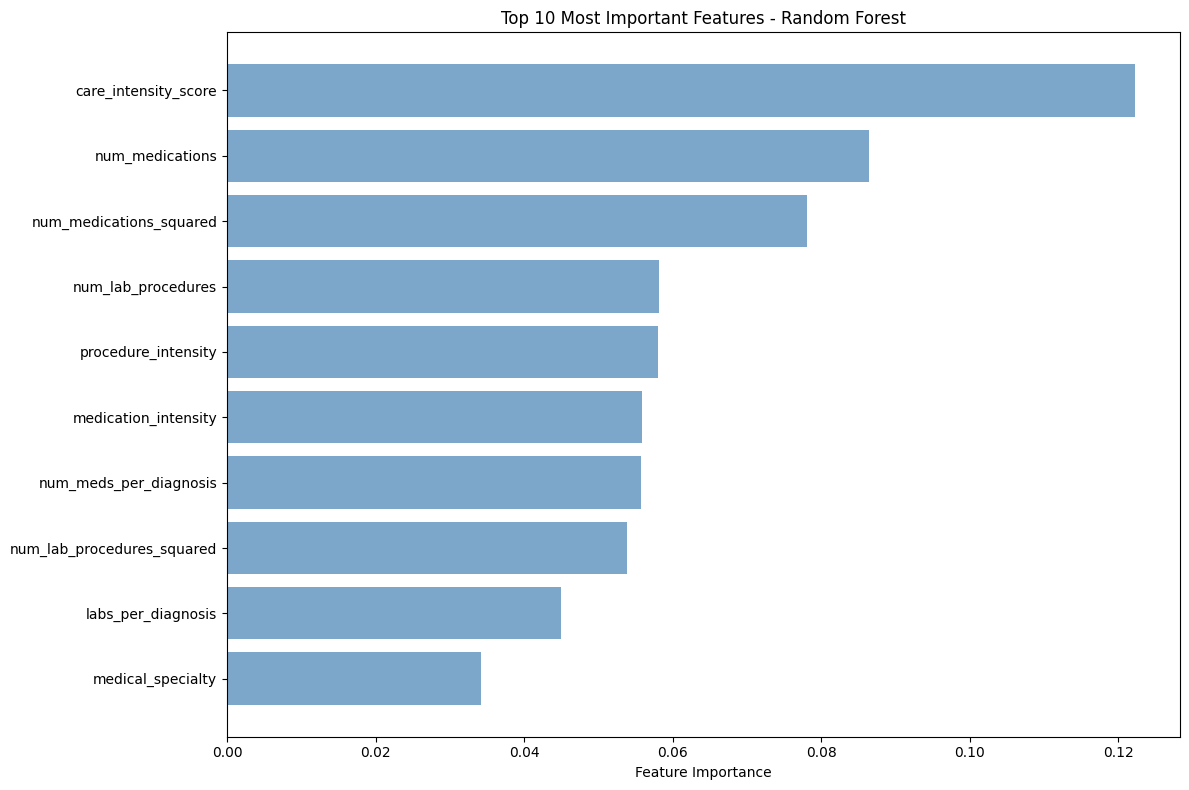

In [ ]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_10_rf = rf_feature_importance.head(10)
plt.barh(range(len(top_10_rf)), top_10_rf['Importance'], alpha=0.7, color='steelblue')
plt.yticks(range(len(top_10_rf)), top_10_rf['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Residual Analysis for Random Forest
rf_residuals = y_test - y_test_pred_rf

print(f"\nResidual Statistics:")
print(f"Mean:   {np.mean(rf_residuals):.4f}")
print(f"Std:    {np.std(rf_residuals):.4f}")
print(f"Min:    {np.min(rf_residuals):.4f}")
print(f"Max:    {np.max(rf_residuals):.4f}")
print(f"Median: {np.median(rf_residuals):.4f}")


Residual Statistics:
Mean:   -0.0509
Std:    2.3123
Min:    -7.6018
Max:    10.9856
Median: -0.4778


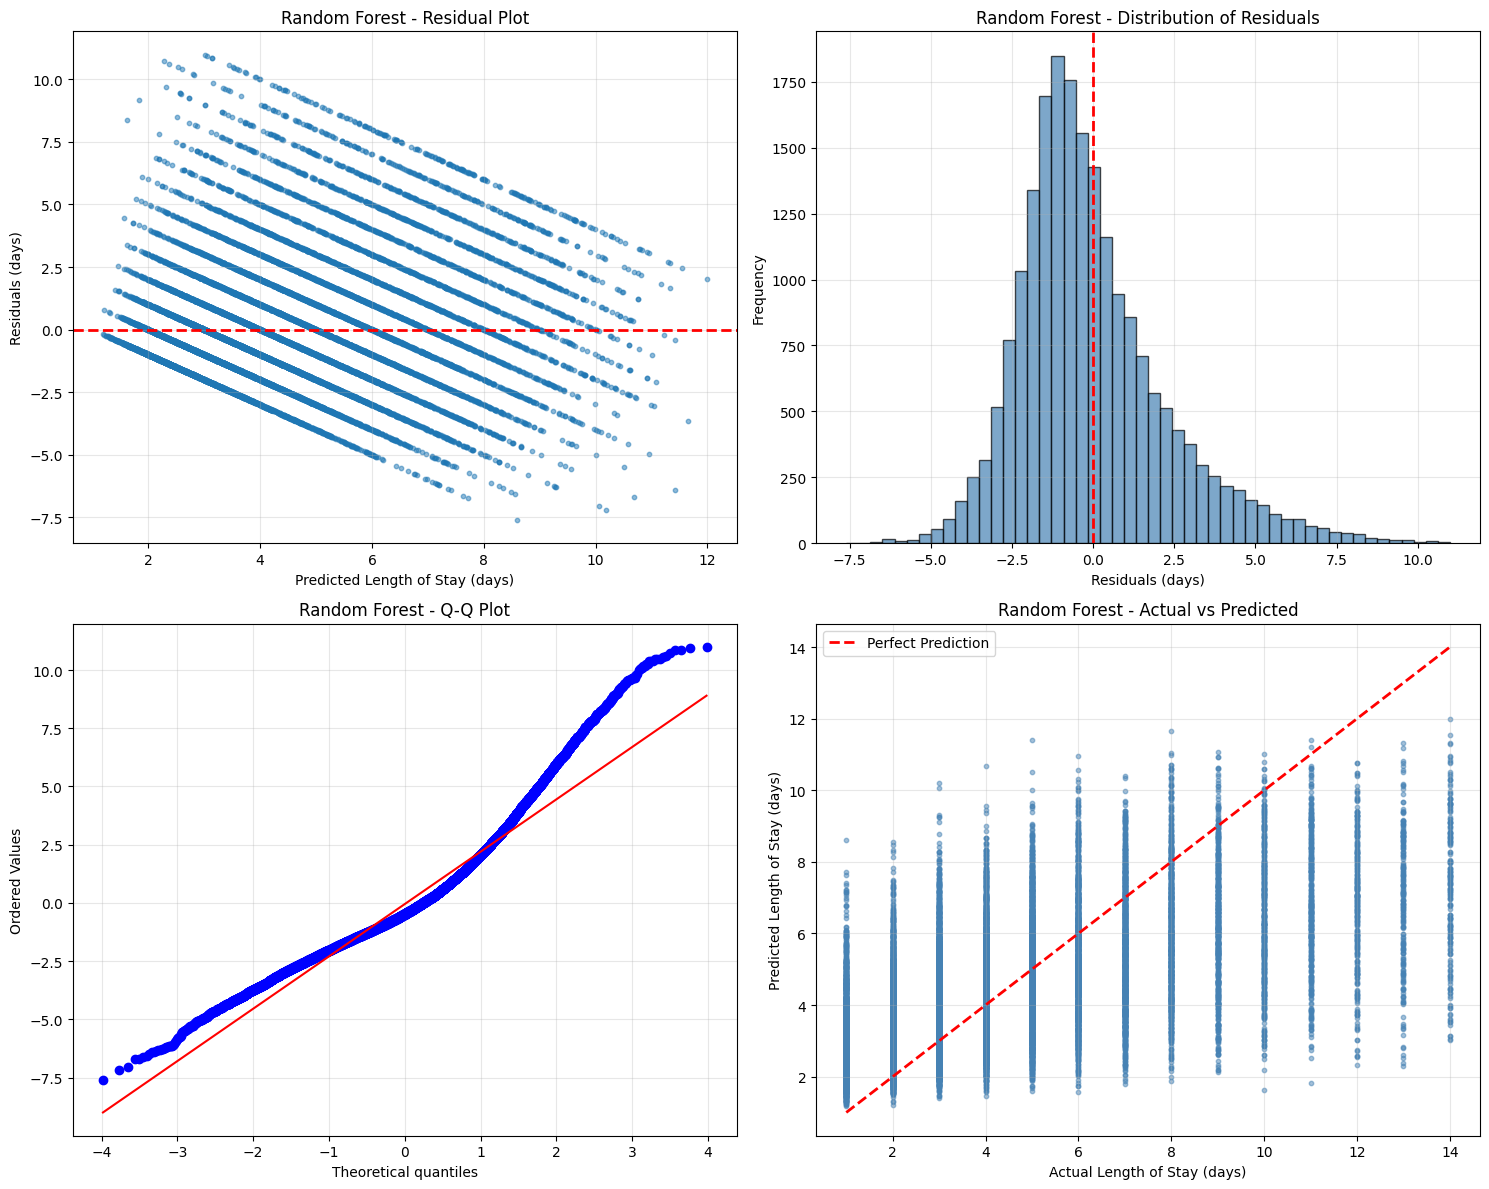

In [ ]:
# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Residuals vs Predicted
axes[0, 0].scatter(y_test_pred_rf, rf_residuals, alpha=0.5, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Length of Stay (days)')
axes[0, 0].set_ylabel('Residuals (days)')
axes[0, 0].set_title('Random Forest - Residual Plot')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Histogram of Residuals
axes[0, 1].hist(rf_residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_xlabel('Residuals (days)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Random Forest - Distribution of Residuals')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Q-Q Plot
stats.probplot(rf_residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Random Forest - Q-Q Plot')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Actual vs Predicted
axes[1, 1].scatter(y_test, y_test_pred_rf, alpha=0.5, s=10, color='steelblue')
axes[1, 1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Length of Stay (days)')
axes[1, 1].set_ylabel('Predicted Length of Stay (days)')
axes[1, 1].set_title('Random Forest - Actual vs Predicted')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Model 5: Gradient Boost

In [ ]:
gb_model = GradientBoostingRegressor(
    n_estimators=400,           # More trees = better performance
    learning_rate=0.05,         # Slower learning = better generalization
    max_depth=5,                # Moderate depth for GB
    min_samples_split=10,       # Conservative splitting
    min_samples_leaf=4,         # Prevents overfitting
    subsample=0.8,              # Stochastic gradient boosting
    max_features='sqrt',        # Feature sampling
    loss='huber',               # Robust to outliers
    random_state=42,
    verbose=0,
    validation_fraction=0.1,    # Early stopping validation
    n_iter_no_change=20,        # Stop if no improvement
    tol=1e-4
)


In [ ]:
# Train the model
gb_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=5,
                          max_features='sqrt', min_samples_leaf=4,
                          min_samples_split=10, n_estimators=400,
                          n_iter_no_change=20, random_state=42, subsample=0.8)

In [ ]:
# Make predictions
y_train_pred_gb = gb_model.predict(X_train_scaled)
y_test_pred_gb = gb_model.predict(X_test_scaled)

In [ ]:
# Calculate metrics
gb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
gb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
gb_train_mae = mean_absolute_error(y_train, y_train_pred_gb)
gb_test_mae = mean_absolute_error(y_test, y_test_pred_gb)
gb_train_r2 = r2_score(y_train, y_train_pred_gb)
gb_test_r2 = r2_score(y_test, y_test_pred_gb)

In [ ]:
# Display results
print("GRADIENT BOOSTING - RESULTS")
print(f"Training RMSE: {gb_train_rmse:.4f} days")
print(f"Test RMSE: {gb_test_rmse:.4f} days")
print(f"Training MAE: {gb_train_mae:.4f} days")
print(f"Test MAE: {gb_test_mae:.4f} days")
print(f"Training R²: {gb_train_r2:.4f}")
print(f"Test R²: {gb_test_r2:.4f}")

GRADIENT BOOSTING - RESULTS
Training RMSE: 2.2653 days
Test RMSE: 2.2863 days
Training MAE: 1.6698 days
Test MAE: 1.6971 days
Training R²: 0.4274
Test R²: 0.3994


In [ ]:
# Feature Importance
gb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features (GradientBoost):")
print(gb_feature_importance.head(10).to_string(index=False))

Top 10 Most Important Features (GradientBoost):
                   Feature  Importance
      care_intensity_score    0.113027
   num_medications_squared    0.098762
           num_medications    0.078972
num_lab_procedures_squared    0.062783
    num_meds_per_diagnosis    0.062071
       procedure_intensity    0.059958
      medication_intensity    0.051282
          number_diagnoses    0.043684
        num_lab_procedures    0.043206
         medical_specialty    0.040276


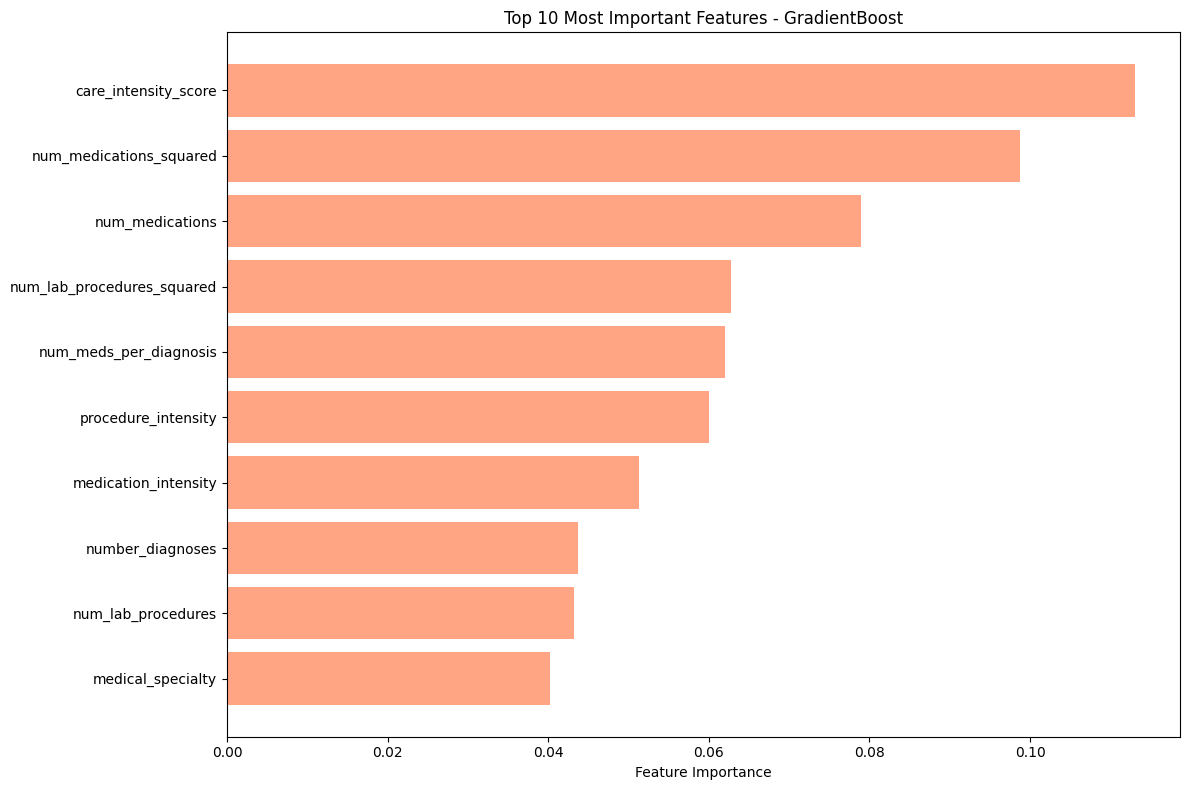

In [ ]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_10_gb = gb_feature_importance.head(10)
plt.barh(range(len(top_10_gb)), top_10_gb['Importance'], alpha=0.7, color='coral')
plt.yticks(range(len(top_10_gb)), top_10_gb['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features - GradientBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Residual Analysis for XGBoost
gb_residuals = y_test - y_test_pred_gb

print(f"\nResidual Statistics:")
print(f"Mean:   {np.mean(gb_residuals):.4f}")
print(f"Std:    {np.std(gb_residuals):.4f}")
print(f"Min:    {np.min(gb_residuals):.4f}")
print(f"Max:    {np.max(gb_residuals):.4f}")
print(f"Median: {np.median(gb_residuals):.4f}")


Residual Statistics:
Mean:   0.1227
Std:    2.2830
Min:    -7.7157
Max:    11.4486
Median: -0.3016


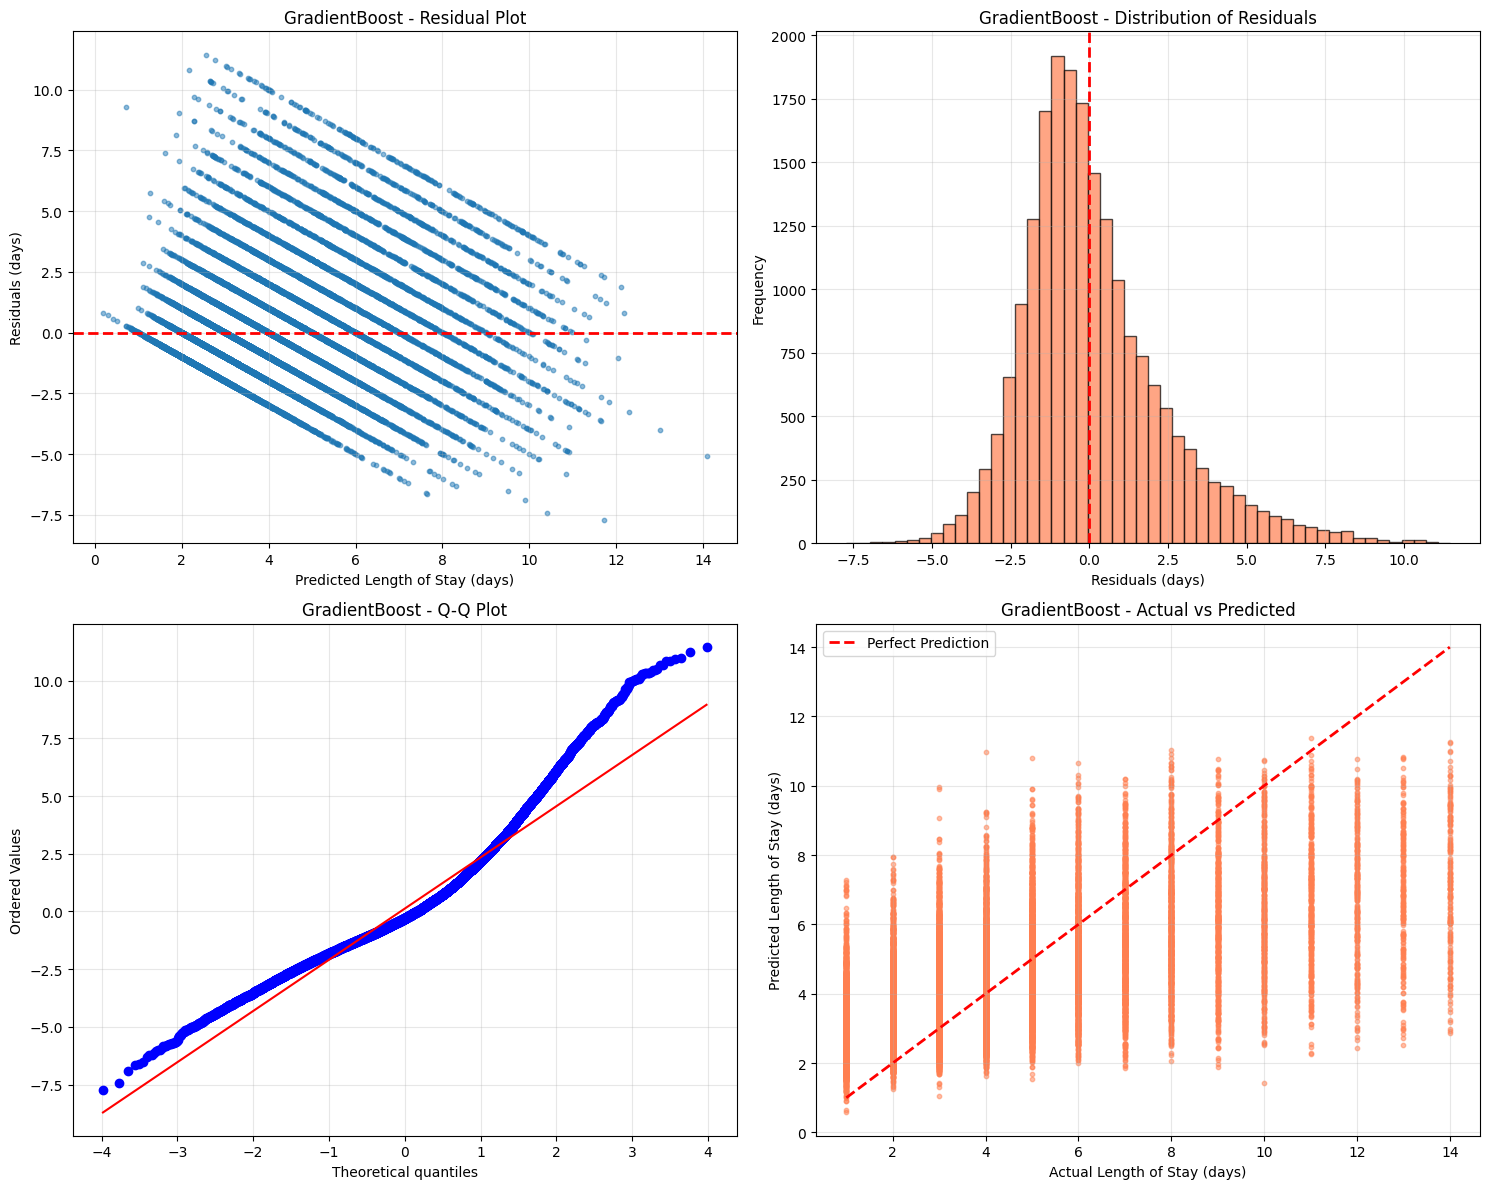

In [ ]:
# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Residuals vs Predicted
axes[0, 0].scatter(y_test_pred_gb, gb_residuals, alpha=0.5, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Length of Stay (days)')
axes[0, 0].set_ylabel('Residuals (days)')
axes[0, 0].set_title('GradientBoost - Residual Plot')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Histogram of Residuals
axes[0, 1].hist(gb_residuals, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Residuals (days)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('GradientBoost - Distribution of Residuals')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Q-Q Plot
stats.probplot(gb_residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('GradientBoost - Q-Q Plot')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Actual vs Predicted
axes[1, 1].scatter(y_test, y_test_pred_xgb, alpha=0.5, s=10, color='coral')
axes[1, 1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Length of Stay (days)')
axes[1, 1].set_ylabel('Predicted Length of Stay (days)')
axes[1, 1].set_title('GradientBoost - Actual vs Predicted')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stacking Ensemble

In [ ]:
# Create base estimators for diff models
estimators = [
    ('rf', RandomForestRegressor(
        n_estimators=400,
        max_depth=25,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )),
    ('gb', GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=4,
        subsample=0.8,
        max_features='sqrt',
        random_state=42
    )),
    ('xgb', xgb.XGBRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
]

In [ ]:
# Create stacking ensemble with Ridge as final estimator
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=10),
    cv=5,
    n_jobs=-1
)

In [ ]:
stack_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=25,
                                                     max_features='sqrt',
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=400,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=5,
                                                         max_features='sqrt',
                                                         min_samples_leaf=4,
                                                         min_samples_split=10,
                                                         n_estimators=400,
                                                         random_state=42,
                                                         subsample=0.8)...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=-1,
                                            num_parallel_tree=None, ...))],
                  final_estimator=Ridge(alpha=10), n_jobs=-1)

In [ ]:
# Make predictions
y_train_pred_stack = stack_model.predict(X_train_scaled)
y_test_pred_stack = stack_model.predict(X_test_scaled)

In [ ]:
# Calculate metrics
stack_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_stack))
stack_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_stack))
stack_train_mae = mean_absolute_error(y_train, y_train_pred_stack)
stack_test_mae = mean_absolute_error(y_test, y_test_pred_stack)
stack_train_r2 = r2_score(y_train, y_train_pred_stack)
stack_test_r2 = r2_score(y_test, y_test_pred_stack)

In [ ]:
print("STACKING ENSEMBLE - RESULTS")
print(f"Training RMSE: {stack_train_rmse:.4f} days")
print(f"Test RMSE:     {stack_test_rmse:.4f} days")
print(f"Training MAE:  {stack_train_mae:.4f} days")
print(f"Test MAE:      {stack_test_mae:.4f} days")
print(f"Training R²:   {stack_train_r2:.4f}")
print(f"Test R²:       {stack_test_r2:.4f}")

STACKING ENSEMBLE - RESULTS
Training RMSE: 2.1182 days
Test RMSE:     2.2579 days
Training MAE:  1.5891 days
Test MAE:      1.7002 days
Training R²:   0.4994
Test R²:       0.4143


## Conclusion

**Stacking Ensemble achieved the best generalization** with the highest Test R² (0.414), explaining 41.4% of variance in hospital stay duration. Its lower training R² (0.499) indicates better balance between bias and variance.

Random Forest showed strong performance but **significant overfitting**...(Training R²: 0.664 vs Test R²: 0.385).

Gradient Boosting performed moderately (Test R²: 0.399) with less overfitting than Random Forest.

Overall, the Stacking Ensemble's best test performance among the 3 demonstrates that combining multiple models effectively captures diverse patterns for predicting hospital length of stay.

AI Tool Usage Disclaimer:

We used Sonnet 4.5 for interaction features combination, GridSearch methods for Ridge Regression, comprehension of the hyperparametes menaing for Random Rorest and Gradient Boost, and Stacking Ensemble methos construction.